# Creating and using Generative Adverserial Neural Networks

*by Bruce Darcy, Dec, 8, 2018*

## Introduction

I have been trying to set up and use open source projects involving generative adverserial neural networks

Generative adverserial neural networks, or GANs, is a method of using two neural networks to create outputs that mimic an input dataset. In the examples I was working with, that data was images, but GANs have been used for many more things, including music, text, voices, and videos. GANs involve a discriminator network, and a generator network. The job of the generator is to try to generate fake images that are simular to ones from the dataset. The job of the discriminator is to try and determine if an image that it recieves is from the generator network, or a real image from the dataset. The loss functions of such networks are based on each other, and in a sense that compete. Often the generator is a deconvolutional neural network, meaning that it starts with some random input, and tries to guess at filters, and build up a fake image using these filters. The discriminator on the other hand is often a convolutional neural network, and as the name suggests, does the opposite. It decomposes the image using filters to try and get more information out of it, which it evenually uses to make a guess at wether the image is fake or real. That also means that the discriminator network has only one output, which will be 0 or 1, while the generator network outputs a whole image. Back propagation is applied to both networks with the error that they get based on each other on each training iteration.As these networks train the go back and forth at getting better at their jobs, which can eventually lead to some really good looking fakes. 

In practice, when we have a fully trained model, we don't really care about what the discriminator network is doing unless we want to resume training later. It inherently has no real application to anything outside the problem, the part we are about is the generative network, which if trained well can provide us with as many decent looking fakes by just running random noise though the network.

## Methods

Initially, I started working with the hypergan open source project, https://github.com/HyperGAN/HyperGAN. Hypergan allows you to train a GAN on an image dataset you provide, with very little programming overhead needed. It is known for work done with generating realistic looking human faces using the software. At the beggining of last summer I had actually been trying to work with the package, but I was not able to make it work with the CUDA version on my laptop.

Populating the interactive namespace from numpy and matplotlib


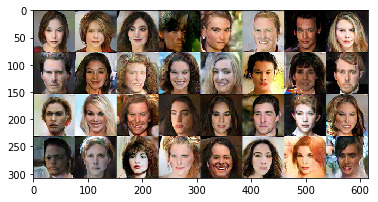

In [31]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('face.png')
imgplot = plt.imshow(img)
plt.show()

Faces are a particularly hard problem to tackle with generative adverserial networks because the human brain is very hardwired to be able to distinguish faces, differences between faces, and features of faces. In this example, there a few faces that look almost real, but you can always tell that something is a little off with the image. Some on the other hand are completely messed up, but the general shape is kind of there. Regardless the fact that the network can create even a few faces that look decently realistic is pretty impressive, especially since faces are very complex and have lots of distinct features.

At the moment, most generative adverserial networks have to talk small input sizes of images, unless you a ton of computing power, because the process takes to much computing power and time. The faces in this example are no more than 256 by 256 pixels, and the data that I showcase later is only 28 by 28 pixels, and they don't have color values, which is the only reason it trains relatively fast.

This time, I started by attempting to install the program on the cs machines, but I found I was going to need to work with a local directory of python since I didn't have access to install packages on the system. I was able to install hypergan itself, and most of its dependancies, but I was hung up by hyperchamber, which had issues installing to a local python directory, preventing me from going forward with hypergan.

I then tried to use art-DCGAN, an oben source project created by Robbie Barrat at Stanford, but I ran up against similar problems on the cs machines. For a while I was having dependancy problems, but I was able to get it to run by removing the code inside the source code that was using a package display in luarocks for displaying the images as it trained, that was having compilation errors when I tried to install it. 

However, here are some example landscapes created by art-DCGAN. The dataset for these was collected from art pages across the internet.

Populating the interactive namespace from numpy and matplotlib


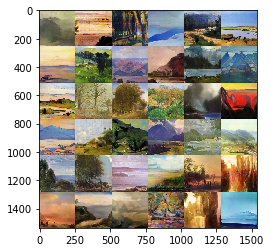

In [32]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('landscapenet_waifu2x.png')
imgplot = plt.imshow(img)
plt.show()

I've been able to train the network, but the images that come out of it don't look good.

Populating the interactive namespace from numpy and matplotlib


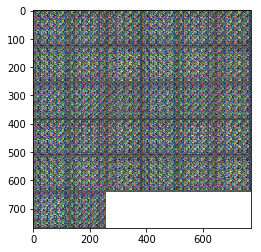

In [29]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('generation1.png')
imgplot = plt.imshow(img)
plt.show()

I trained this model for 100 epochs, which took about 20 minutes on the lotus machine in the cs building. I'm not sure it its because the mnist dataset contains too small of images, or because it hasnt trained long enough. The code is able to accurately detect how many input images I am feeding it. I wonder if also it might not be reading the image files correctly.

I tried training a model for 500 epochs, but the program crashed before it could finish.

The third software I tried to use was cycleGAN, but again, dependancy issues prevented me from moving forward. As with a lot of these my laptop graphics card would not suffice for driver reasons, OS reasons or others, and the CS machines would cause errors when trying to install to local directories, though I tried many things.

I started working with the GAN module in tensorflow. Tensorflow defines a way for you to specify GAN networks in an abstracted way. I ran an example from the mnist dataset, and the results are below. __I did not write and do not own the following code, it is from an example in the tensorflow models library.__

Here we are working with the mnist data set of hand written numbers, the following code reads the data in.

In [14]:
MNIST_DATA_DIR = '/tmp/mnist-data'

if not tf.gfile.Exists(MNIST_DATA_DIR):
    tf.gfile.MakeDirs(MNIST_DATA_DIR)

download_and_convert_mnist.run(MNIST_DATA_DIR)

Dataset files already exist. Exiting without re-creating them.


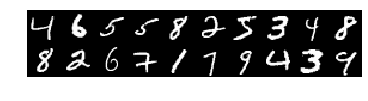

In [33]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', batch_size, MNIST_DATA_DIR)

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:20,...], num_cols=10)
visualize_digits(check_real_digits)

Here are what the input images look like for this model. The images are taken from real handwritten numbers from people, and put into a scale only between black and white.

The tensorsflow api allow you to create a generative adverserial net by specifying only a few thing. Below are the code the define the generator network, and the discriminator network. Again, the generator is supposed to generate good looking fake images, and the discriminator is supposed to be able to tell the difference between the two.

In [16]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

Here in the generator function, we can see that we are using convulution layers toward the end. The purpose of these layers is to try to add in filters that can add together to make a meaningful picture, rather than more random seeming stuff. Even random combinations of these filters will seem more meaningful than a network without them.

The discriminator network on the other hand, starts with the convulution layers, to pull out features early that can be used to infer useful information about the image that can be reduced down though the other layers to finally make a prediction about wether the image it is looking at is fake or real.

In [17]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

Here is some code that gives us information about loss in the network. To my understanding loss is information about how much error the network is making.

In [19]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

vanilla loss generator loss: -0.991992
vanilla loss discriminator loss: 1.448796
improved wgan loss generator loss: 0.671612
improved wgan loss discriminator loss: 0.086709
custom loss generator loss: -0.135652
custom loss discriminator loss: 0.134683


Here we have how you actually define a genetative adverserial net in tensorflow. Using the tfgan module, which can be found in tensorflow.contrib.gan, you can define a generative network from just the generator function, discriminator function, input data, and generator inputs, which are usually kept random. As you can see there the input to the generator network is just random noise.

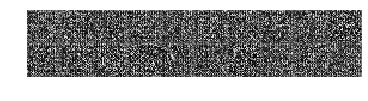

In [10]:
noise_dims = 64
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
check_generated_digits = tfgan.eval.image_reshaper(
    gan_model.generated_data[:20,...], num_cols=10)
visualize_digits(check_generated_digits)

Here we are able to define how the training of the model happens, with the model of the function, a loss funtion, and optimization functions for both networks

In [12]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

I trained the generative network on hte mnist data for 1600 iterations on my laptop. It took about 20 minutes, and the numbers that the generator is producing by the end look pretty realistic, and honestly I don't know if I could tell you which one was the fake if you put them side by side to the real input data.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
iterations: 0
Current loss: 0.750741
Current MNIST score: 1.000072
Current Frechet distance: 337.256073
Training step: 0
Time since start: 0.092607 m
Steps per min: 0.000000


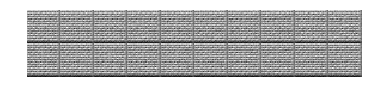

iterations: 10
iterations: 20
iterations: 30
iterations: 40
iterations: 50
iterations: 60
iterations: 70
iterations: 80
iterations: 90
iterations: 100
iterations: 110
iterations: 120
iterations: 130
iterations: 140
iterations: 150
iterations: 160
iterations: 170
iterations: 180
iterations: 190
iterations: 200
Current loss: -2.535039
Current MNIST score: 1.637369
Current Frechet distance: 230.675858
Training step: 200
Time since start: 2.879213 m
Steps per min: 69.463434


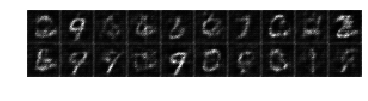

iterations: 210
iterations: 220
iterations: 230
iterations: 240
iterations: 250
iterations: 260
iterations: 270
iterations: 280
iterations: 290
iterations: 300
iterations: 310
iterations: 320
iterations: 330
iterations: 340
iterations: 350
iterations: 360
iterations: 370
iterations: 380
iterations: 390
iterations: 400
Current loss: -1.966496
Current MNIST score: 5.696779
Current Frechet distance: 62.020412
Training step: 400
Time since start: 5.657996 m
Steps per min: 70.696405


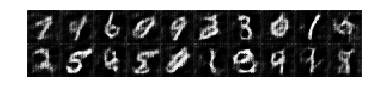

iterations: 410
iterations: 420
iterations: 430
iterations: 440
iterations: 450
iterations: 460
iterations: 470
iterations: 480
iterations: 490
iterations: 500
iterations: 510
iterations: 520
iterations: 530
iterations: 540
iterations: 550
iterations: 560
iterations: 570
iterations: 580
iterations: 590
iterations: 600
Current loss: -2.017591
Current MNIST score: 6.991537
Current Frechet distance: 35.517155
Training step: 600
Time since start: 8.254539 m
Steps per min: 72.687286


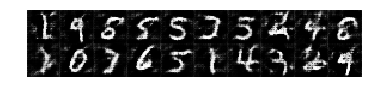

iterations: 610
iterations: 620
iterations: 630
iterations: 640
iterations: 650
iterations: 660
iterations: 670
iterations: 680
iterations: 690
iterations: 700
iterations: 710
iterations: 720
iterations: 730
iterations: 740
iterations: 750
iterations: 760
iterations: 770
iterations: 780
iterations: 790
iterations: 800
Current loss: -2.296932
Current MNIST score: 6.891226
Current Frechet distance: 47.768585
Training step: 800
Time since start: 10.827816 m
Steps per min: 73.883783


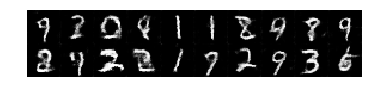

iterations: 810
iterations: 820
iterations: 830
iterations: 840
iterations: 850
iterations: 860
iterations: 870
iterations: 880
iterations: 890
iterations: 900
iterations: 910
iterations: 920
iterations: 930
iterations: 940
iterations: 950
iterations: 960
iterations: 970
iterations: 980
iterations: 990
iterations: 1000
Current loss: -1.614295
Current MNIST score: 7.181209
Current Frechet distance: 40.197594
Training step: 1000
Time since start: 13.378724 m
Steps per min: 74.745543


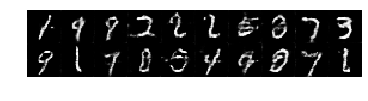

iterations: 1010
iterations: 1020
iterations: 1030
iterations: 1040
iterations: 1050
iterations: 1060
iterations: 1070
iterations: 1080
iterations: 1090
iterations: 1100
iterations: 1110
iterations: 1120
iterations: 1130
iterations: 1140
iterations: 1150
iterations: 1160
iterations: 1170
iterations: 1180
iterations: 1190
iterations: 1200
Current loss: -2.002323
Current MNIST score: 6.940781
Current Frechet distance: 45.084316
Training step: 1200
Time since start: 15.933522 m
Steps per min: 75.312915


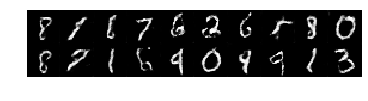

iterations: 1210
iterations: 1220
iterations: 1230
iterations: 1240
iterations: 1250
iterations: 1260
iterations: 1270
iterations: 1280
iterations: 1290
iterations: 1300
iterations: 1310
iterations: 1320
iterations: 1330
iterations: 1340
iterations: 1350
iterations: 1360
iterations: 1370
iterations: 1380
iterations: 1390
iterations: 1400
Current loss: -2.800963
Current MNIST score: 7.324739
Current Frechet distance: 38.804321
Training step: 1400
Time since start: 18.514927 m
Steps per min: 75.614665


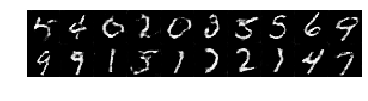

iterations: 1410
iterations: 1420
iterations: 1430
iterations: 1440
iterations: 1450
iterations: 1460
iterations: 1470
iterations: 1480
iterations: 1490
iterations: 1500
iterations: 1510
iterations: 1520
iterations: 1530
iterations: 1540
iterations: 1550
iterations: 1560
iterations: 1570
iterations: 1580
iterations: 1590
iterations: 1600
Current loss: -3.752147
Current MNIST score: 7.711945
Current Frechet distance: 29.584087
Training step: 1600
Time since start: 21.147123 m
Steps per min: 75.660409


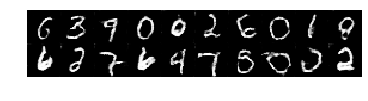

In [22]:
# We have the option to train the discriminator more than one step for every 
# step of the generator. In order to do this, we use a `GANTrainSteps` with 
# desired values. For this example, we use the default 1 generator train step 
# for every discriminator train step.
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_scores, frechet_distances  = [], [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in xrange(1601):
        cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
        loss_values.append((i, cur_loss))
        if i % 10 == 0: print('iterations: ' + str(i))
        if i % 200 == 0:
            mnist_score, f_distance, digits_np = sess.run(
                [eval_score, frechet_distance, generated_data_to_visualize])
            mnist_scores.append((i, mnist_score))
            frechet_distances.append((i, f_distance))
            print('Current loss: %f' % cur_loss)
            print('Current MNIST score: %f' % mnist_scores[-1][1])
            print('Current Frechet distance: %f' % frechet_distances[-1][1])
            visualize_training_generator(i, start_time, digits_np)

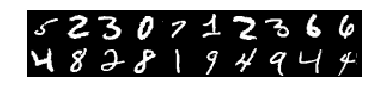

In [34]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    real_images, _, _ = data_provider.provide_data(
        'train', batch_size, MNIST_DATA_DIR)

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:20,...], num_cols=10)
visualize_digits(check_real_digits)

Here are the a few of the inputs to the network again. As you can see the fakes look pretty close to the real thing, and there are several where I could not tell the difference myself.

## Results

Here is some information about the loss function of the network as the training happens. 

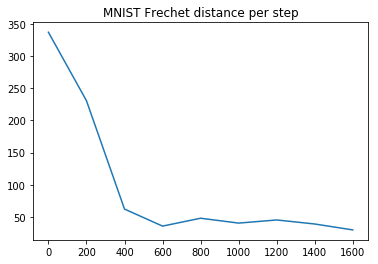

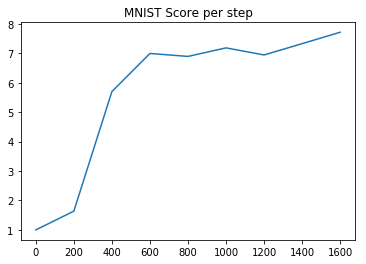

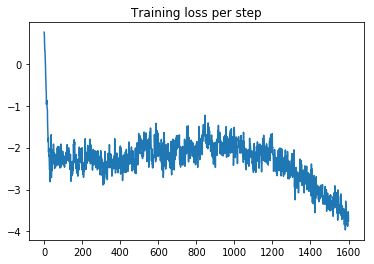

In [23]:
# Plot the eval metrics over time.
plt.title('MNIST Frechet distance per step')
plt.plot(*zip(*frechet_distances))
plt.figure()
plt.title('MNIST Score per step')
plt.plot(*zip(*mnist_scores))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))

It seems that the network starts to hit a peak after about 600 iterations. The frechet inception distance is a mathematical method that is able to give some insight to how good of fakes generated samples are. It seems to tail on somewhat asymptotically toward the end of the training. We can also see the the loss tends to fluctuate a lot between the training samples. This makes sense, because since you have two networks competing with each other, it should kind of look like leap frog like learning, where one learns to beat the other, then the other learns from that.

I also tried putting in data from the fashion mnist data set into this network structure, but I was not able to make the data pipeline for it work in a reasonable amount of time unfortunately. This example is actually from tensorflow, and I am using it to showcase what I have learned and what generative adverserial networks do.

## Conclusions

This project ended up being a lot harder than I thought it would be. I spent most of my time just trying to figure out dpeendancies in packages, most of which ended up not even working anyway. It was cool to see the generative adverserial networks that did end up producing results work. It is a very interesting appilcation of neural networks. Also, the tensorflow built in capabilities to create generative adverserial networks are nice, and do a lot of things for you. It seems that the problem with a playing with a lot of these open source projects, is that they are built to work on the current verions of all the software they use at the time that the code was written and the project was developed. I ran into errors many time, that would have required me to downgrade my cuda software to run the programs. I tried doing some of that on my laptop, but since it has a laptop version of a graphics card, it's a little funky and didn't end up working out. Luckly I was able to get art-DCGAN to run somewhat, even though there were more problems with my inputs. 

I really wanted to be able to play around with the network structure and fuction more in this project, but unfortunately I spent most of my time just trying to get the packages to work.

I would definently say that something I have learned from this is that the high level apis for GANs, (such as the one for tensorflow, and I would assume pytorch has a similar function somewhere) seem to be the way to go to try to mess around with some simple GAN projects.

This project has definitely been a learning experience about when to move on to another approach when you just can't seem to get past a brick wall of a problem, I spent so much time trying to make hyperGAN work early on into the project, that I didn't have enough left to work with the tensorflow apis once I was able to get something up and running.

### References

* HyperGAN, (2018), GitHub repository, https://github.com/HyperGAN/HyperGAN 
* Barrat Robbie, art-DCGAN, (2018), GitHub repository, https://github.com/robbiebarrat/art-DCGAN
* Shor, Joel. “TFGAN: A Lightweight Library for Generative Adversarial Networks.” Google Open Source Blog, opensource.googleblog.com/2017/12/tfgan-lightweight-library-for-generative-adversarial-networks.html.
* tfGAN/Tensorflow Models , (2018), GitHub repository, https://github.com/tensorflow/models
* CycleGAN , (2018), GitHub repository,  https://github.com/junyanz/CycleGAN
* Fashon MNIST , (2018), GitHub repository, https://github.com/zalandoresearch/fashion-mnist
*Sudhir, Kiran. “Generative Adversarial Networks- History and Overview.” Towards Data Science, Towards Data Science, 21 June 2017, towardsdatascience.com/generative-adversarial-networks-history-and-overview-7effbb713545.


In [3]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('Project Report Example.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

IndexError: list index out of range